# Explore Data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
path_to_data = 'data/DataCoSupplyChainDataset.csv'
data = pd.read_csv(path_to_data, encoding='latin-1')

### 1. What is the nature of data available to you?

In [4]:
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [13]:
for col in data.columns.values:
    print(col)

Type
Days for shipping (real)
Days for shipment (scheduled)
Benefit per order
Sales per customer
Delivery Status
Late_delivery_risk
Category Id
Category Name
Customer City
Customer Country
Customer Email
Customer Fname
Customer Id
Customer Lname
Customer Password
Customer Segment
Customer State
Customer Street
Customer Zipcode
Department Id
Department Name
Latitude
Longitude
Market
Order City
Order Country
Order Customer Id
order date (DateOrders)
Order Id
Order Item Cardprod Id
Order Item Discount
Order Item Discount Rate
Order Item Id
Order Item Product Price
Order Item Profit Ratio
Order Item Quantity
Sales
Order Item Total
Order Profit Per Order
Order Region
Order State
Order Status
Order Zipcode
Product Card Id
Product Category Id
Product Description
Product Image
Product Name
Product Price
Product Status
shipping date (DateOrders)
Shipping Mode


### 2. What are other (additional) data sources you can access to achieve your objectives?

- We can leverage the geopy Python package for coverting addresses to Latitude Longitude to use as a training feature when trying to predict something about the timeliness of the delivery.

https://pypi.org/project/geopy/

- We can look into literature on how month of year affects deliveries across the world, motivated by how customers care about delivery time.


https://www.marketingcharts.com/industries/retail-and-e-commerce-82710

https://www.hollingsworthllc.com/how-late-deliveries-impact-customer-retention/


### 3. Prepare the data for AutoML (DataRobot)

TODO:

1. Convert Customer Country, State, City, Zipcode, Street to longitude-latitude with geopy
2. Calculated euclidean distance between customer and store given the longitude-latitude pairs
3. Convert shipping date to categorical data by month (one-hot encoding)
4. Convert shipping mode to categorical data (one-hot encoding)
5. Convert delivery status to categorical data (one-hot encoding)
6. Create a feature representing the recent customer demand for a given product
7. Create a feature repren

In [26]:
relevant_columns = [
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Delivery Status',
    'Late_delivery_risk',
    'Customer City',
    'Customer Country',
    'Customer State',
    'Customer Street',
    'Customer Zipcode',
    'Latitude',
    'Longitude',
    'shipping date (DateOrders)',
    'Shipping Mode'
]
X_df = data[relevant_columns]
X_df.head()

,Days for shipping (real),Days for shipment (scheduled),Delivery Status,Late_delivery_risk,Customer City,Customer Country,Customer State,Customer Street,Customer Zipcode,Latitude,Longitude,shipping date (DateOrders),Shipping Mode
0,3,4,Advance shipping,0,Caguas,Puerto Rico,PR,5365 Noble Nectar Island,725.0,18.251453,-66.037056,2/3/2018 22:56,Standard Class
1,5,4,Late delivery,1,Caguas,Puerto Rico,PR,2679 Rustic Loop,725.0,18.279451,-66.037064,1/18/2018 12:27,Standard Class
2,4,4,Shipping on time,0,San Jose,EE. UU.,CA,8510 Round Bear Gate,95125.0,37.292233,-121.881279,1/17/2018 12:06,Standard Class
3,3,4,Advance shipping,0,Los Angeles,EE. UU.,CA,3200 Amber Bend,90027.0,34.125946,-118.291016,1/16/2018 11:45,Standard Class
4,2,4,Advance shipping,0,Caguas,Puerto Rico,PR,8671 Iron Anchor Corners,725.0,18.253769,-66.037048,1/15/2018 11:24,Standard Class


### 4. Conduct exploratory data analysis

C:\Users\caleb\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


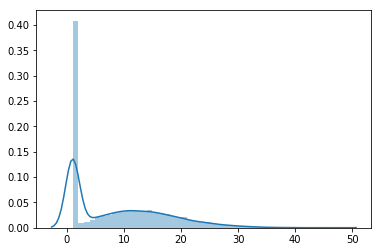

In [6]:
customer_freq = data['Customer Id'].value_counts().values
sns.distplot(customer_freq)

In [17]:
delivery_days_sched = data['Days for shipment (scheduled)']
delivery_days_real = data['Days for shipping (real)']
delivery_days_ME = ((delivery_days_sched - delivery_days_real).abs()).mean()
delivery_days_MSE = ((delivery_days_sched - delivery_days_real) ** 2).mean()
print("Delivery Days (scheduled) Value Counts\n", delivery_days_sched.value_counts(), "\n")
print("Delivery Days (real) Value Counts\n", delivery_days_real.value_counts(), "\n")
print("Delivery Days ME:", delivery_days_ME)
print("Delivery Days MSE:", delivery_days_MSE)

Delivery Days (scheduled) Value Counts
 4    107752
2     35216
1     27814
0      9737
Name: Days for shipment (scheduled), dtype: int64 

Delivery Days (real) Value Counts
 2    56618
3    28765
6    28723
4    28513
5    28163
0     5080
1     4657
Name: Days for shipping (real), dtype: int64 

Delivery Days ME: 1.2863078124740333
Delivery Days MSE: 2.543106265822434


In [15]:
late_delivery_risk = data['Late_delivery_risk']
print("Late Delivery Risk Value Counts\n", late_delivery_risk.value_counts(), "\n")

Late Delivery Risk Value Counts
 1    98977
0    81542
Name: Late_delivery_risk, dtype: int64 



In [16]:
delivery_status = data['Delivery Status']
print("Delivery Status Value Counts\n", delivery_status.value_counts(), "\n")

Delivery Status Value Counts
 Late delivery        98977
Advance shipping     41592
Shipping on time     32196
Shipping canceled     7754
Name: Delivery Status, dtype: int64 



### 5. Address target leakage